# Churn Prediction with Text and Interpretability

This notebook runs the entire churn prediction pipeline from data preparation to model evaluation and interpretation.

### Setup

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import yaml
from IPython.display import HTML

os.chdir("../scripts")

import preprocess
import train

In [2]:
with open("../model/params.yaml", "r") as params_file:
    params = yaml.safe_load(params_file)

model_dir = params['model_dir']
data_dir = params['data_dir']

In [3]:
os.environ['PYTHONIOENCODING'] = 'utf-8'

%load_ext autoreload
%autoreload 2

### Load and Prepare the Data

In [4]:
import pandas as pd
import csv
from pathlib import Path
from preprocess import create_joint_dataset

df_categorical = pd.read_csv(Path(data_dir, "train.csv"))
df_text = pd.read_excel(Path(data_dir, "text.xlsx"))
df_text.to_csv(Path(data_dir, 'df_text.csv'), 
               index=False, 
               encoding='utf-8-sig', 
               quoting=csv.QUOTE_NONNUMERIC)
print(f"Input shapes:")
print(f"  df_categorical: {df_categorical.shape}")
print(f"  df_text: {df_text.shape}")
print(f"  df_text churn: {df_text['churn'].value_counts().to_dict()}")

df = create_joint_dataset(df_categorical, df_text)
print(f"\nOutput:")
print(f"  df shape: {df.shape}")
print(f"  df churn: {df['churn'].value_counts().to_dict()}")

df.to_csv(Path(data_dir, "churn_dataset.csv"), index=False)

Input shapes:
  df_categorical: (3941, 11)
  df_text: (1184, 2)
  df_text churn: {1: 603, 0: 581}

Output:
  df shape: (1184, 12)
  df churn: {1: 603, 0: 581}


In [5]:
from preprocess import run_preprocessing

run_preprocessing(use_existing=True)

 Saved to ..\data


In [6]:
df = pd.read_csv("../data/churn_dataset.csv")
df.head(5)

,churn,chat_log,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount
0,0,Customer: I need to know if this specific bran...,27.0,9.0,5,Grocery,1,Married,4,0,8.0,279.27
1,1,Customer: I was charged an annual fee for a se...,14.0,10.0,5,Mobile Phone,3,Married,3,1,3.0,151.83
2,1,Customer: I received a notification that my or...,20.0,NaN,3,Mobile,3,Single,5,0,0.0,124.79
3,0,"Customer: I'm married, and I'm looking to upda...",8.0,NaN,3,Mobile,3,Married,2,0,0.0,124.04
4,1,Customer: I tried to use the 'Price Match' too...,1.0,29.0,4,Mobile Phone,3,Married,6,1,2.0,146.32


### Train and Evaluate the Model

In [7]:
%reload_ext autoreload

In [8]:
data_dir = Path("../data")

train_df_full = pd.read_csv(data_dir / "train2.csv")
test_df_full = pd.read_csv(data_dir / "test2.csv")

TESTING_MODE = False
N_SAMPLES = 200

if TESTING_MODE:
    print(f"TESTING MODE: Using only first {N_SAMPLES} samples")
    train_df = train_df_full.head(N_SAMPLES)
    test_df = test_df_full.head(50)
    print(f"Original: {len(train_df_full)} train, {len(test_df_full)} test")
else:
    train_df = train_df_full
    test_df = test_df_full

print(f"Using: {len(train_df)} train, {len(test_df)} test")
print(f"Churn rate (train): {train_df['churn'].mean():.2%}")
print(f"Churn rate (test): {test_df['churn'].mean():.2%}")

Using: 947 train, 237 test
Churn rate (train): 50.90%
Churn rate (test): 51.05%


In [9]:
numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [c for c in numerical_cols if c != 'churn']

categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [c for c in categorical_cols if c != 'chat_log']

print(f"Numerical: {len(numerical_cols)}, Categorical: {len(categorical_cols)}")

# Prepare data with CONSISTENT variable names
# train_model expects: X_train, y_train, X_test, y_test, text_train, text_test
X_train = train_df[numerical_cols + categorical_cols]
y_train = train_df['churn'].values
text_train = train_df['chat_log'].values

X_test = test_df[numerical_cols + categorical_cols]
y_test = test_df['churn'].values
text_test = test_df['chat_log'].values

print(f"X_train shape: {X_train.shape}")
print(f"Text samples: {len(text_train)}")

Numerical: 8, Categorical: 2
X_train shape: (947, 10)
Text samples: 947


In [11]:
import train
combined_model, xgb_model, test_loader = train.train_model(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    text_train=text_train,
    text_test=text_test
)

Epoch 1 Batch 10 | Avg Weights -> Text: 0.0626, Tabular: 0.0634
Epoch 1 Batch 20 | Avg Weights -> Text: 0.0629, Tabular: 0.0635
Epoch 1 Batch 30 | Avg Weights -> Text: 0.0632, Tabular: 0.0635
Epoch 1 Batch 40 | Avg Weights -> Text: 0.0641, Tabular: 0.0635
Epoch 1 Batch 50 | Avg Weights -> Text: 0.0654, Tabular: 0.0635
Epoch 1 Batch 60 | Avg Weights -> Text: 0.0663, Tabular: 0.0635
Epoch 1: Loss=0.8800, TrainAUC=1.0000, TestAUC=0.9999
Epoch 2 Batch 10 | Avg Weights -> Text: 0.0669, Tabular: 0.0635
Epoch 2 Batch 20 | Avg Weights -> Text: 0.0673, Tabular: 0.0635
Epoch 2 Batch 30 | Avg Weights -> Text: 0.0675, Tabular: 0.0635
Epoch 2 Batch 40 | Avg Weights -> Text: 0.0678, Tabular: 0.0635
Epoch 2 Batch 50 | Avg Weights -> Text: 0.0680, Tabular: 0.0635
Epoch 2 Batch 60 | Avg Weights -> Text: 0.0681, Tabular: 0.0635
Epoch 2: Loss=0.1081, TrainAUC=1.0000, TestAUC=1.0000
Epoch 3 Batch 10 | Avg Weights -> Text: 0.0682, Tabular: 0.0635
Epoch 3 Batch 20 | Avg Weights -> Text: 0.0683, Tabular: 0.0

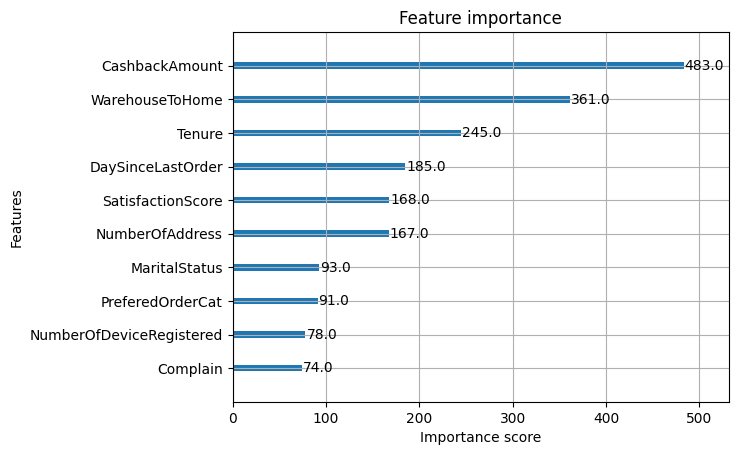

In [12]:
%reload_ext autoreload
from train import train_model
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(xgb_model, max_num_features=10)
plt.show()

In [13]:
from train import evaluate_model
test_auc = evaluate_model(combined_model, test_loader)
print(f"Test AUC: {test_auc:.4f}")

Test AUC: 1.0000


In [14]:
import torch
import joblib
import numpy as np
from pathlib import Path
from transformers import DistilBertTokenizer

from train import DistilBertTextClassifier, TabularModel, CombinedModel, predict, predict_with_xgboost

pred1 = predict(X_test, text_test)
pred2 = predict_with_xgboost(X_test)

print("Combined model prob:", pred1[0])
print("XGBoost prob:", pred2[0])

DEBUG - Text features (first 5): [ 5.4173503  3.2380745  3.504931  -8.492517  11.257742 ]
DEBUG - Tabular features (first 5): [0.09754226 0.08385756 0.         0.07768641 0.        ]
Combined model prob: 5.5152273e-06
XGBoost prob: 0.9989536


In [15]:
from train import plot_roc_curve, plot_pr_curve
plot_roc_curve(X_test, text_test, y_test)
plot_pr_curve(X_test, text_test, y_test)
    
print("Evaluation plots saved to:", model_dir)

DEBUG - Text features (first 5): [ 5.4173503  3.2380745  3.504931  -8.492517  11.257742 ]
DEBUG - Tabular features (first 5): [0.09754226 0.08385756 0.         0.07768641 0.        ]
DEBUG - Text features (first 5): [ 5.4173503  3.2380745  3.504931  -8.492517  11.257742 ]
DEBUG - Tabular features (first 5): [0.09754226 0.08385756 0.         0.07768641 0.        ]
Evaluation plots saved to: ../model


### Interpret the Model

#### Categorical and Numerical Features

In [48]:
%reload_ext autoreload
import sys
import webbrowser
from IPython.display import display, HTML, Image
import interpret

In [37]:
xgb_model = joblib.load("../model/xgboost_model.joblib")
feature_cols = xgb_model.get_booster().feature_names

XGBoost model interpretation

Analyzing 237 samples with 10 features...

Computing feature importance...
Top 10 important features:
                    feature  importance
0                    Tenure    0.300635
5                  Complain    0.160741
9             MaritalStatus    0.080808
3         SatisfactionScore    0.079190
8          PreferedOrderCat    0.076966
7            CashbackAmount    0.071790
6         DaySinceLastOrder    0.065115
4           NumberOfAddress    0.062571
1           WarehouseToHome    0.051404
2  NumberOfDeviceRegistered    0.050782
Feature importance plot saved

Computing SHAP values...
SHAP summary plot saved


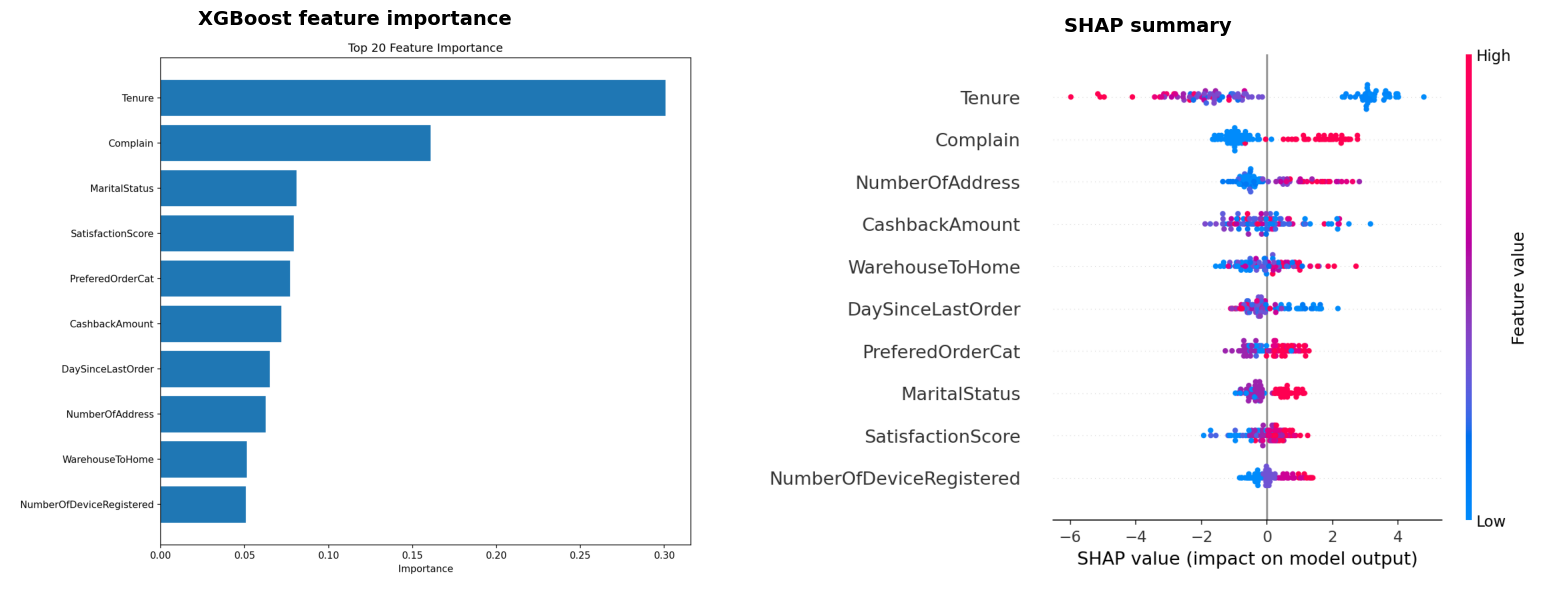

In [38]:
interpret.interpret_tabular_model()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

img1 = plt.imread('../model/xgb_feature_importance.png')
axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('XGBoost feature importance', fontsize=14, fontweight='bold')

img2 = plt.imread('../model/shap_summary.png')
axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('SHAP summary', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

#### Textual Features (focus on customer chats that result in churn)

In [39]:
output_dir, attention_results, gradient_results = interpret.explain_text_with_attention(
    max_samples=5
)

TEXT INTERPRETATION


DistilBertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Processing 5 samples...

Sample 1/5

Sample 2/5

Sample 3/5

Sample 4/5

Sample 5/5

Explanations saved to: ..\model\text_explanations
Results saved to: ..\model\text_explanations\interpretation_results.pkl


##### Create joint metric (semantic similarity + marginal contribution + count)

In [49]:
from collections import defaultdict
import interpret
from interpret import (
    get_important_keywords,
    obtain_context,
    analyze_keyword_cooccurrence,
    visualize_keyword_importance,
    create_keyword_summary_report
)

##### Context of keywords

In [50]:
test_df = pd.read_csv("../data/test2.csv")
chats_list = test_df['chat_log'].dropna().tolist()

results_df = get_important_keywords(
    attention_results=attention_results,
    gradient_results=gradient_results,
    top_k=50,
    min_count=2
)

print("Top 20:")
print(results_df.head(20))

KEYWORD ANALYSIS
Processing 5 attention results
Processing 5 gradient results
Filtered 34 stopwords/invalid tokens
Identified 7 valid keywords
Returning top 7

Top 20:
   rank        keyword  frequency  avg_attention  max_attention  avg_gradient  \
4     1      apologize          2       0.012253       0.015215      0.000396   
2     2        feature          2       0.008696       0.012102      0.000162   
6     3         simple          2       0.006001       0.006757      0.000031   
5     4  authorization          2       0.005367       0.007319      0.000068   
1     5          right          2       0.003870       0.004879      0.000024   
3     6        current          2       0.002863       0.003154      0.000033   
0     7            new          2       0.002803       0.003028      0.000050   

   max_gradient  combined_score  combined_score_with_freq  
4      0.000663        0.007510                  0.008251  
2      0.000273        0.005283                  0.005803  
6  

In [51]:
keyword = results_df.iloc[0]['keyword']
contexts = obtain_context(
    chats_list=chats_list,
    keyword=keyword,
    max_examples=10
)

CONTEXT ANALYSIS: 'apologize'

Found 10 occurrences
Showing 10 examples:

[Example 1] Chat ID: 1, Position: 126
  ...ic payment should have cleared days ago.
Agent: I apologize . It appears your bank had a temporary authorizati...

[Example 2] Chat ID: 3, Position: 121
  ...rashing when I select the return reason.
Agent: I apologize for the buggy interface.
Customer: So I have to u...

[Example 3] Chat ID: 5, Position: 251
  ...at was me logging in from my new laptop!
Agent: I apologize for the overzealous security. I have manually ver...

[Example 4] Chat ID: 13, Position: 106
  ...' that was nowhere on the checkout page.
Agent: I apologize for the lack of transparency. That is a mandated...

[Example 5] Chat ID: 16, Position: 148
  ...xed in 24 hours. It's been 36.
Agent: I sincerely apologize for the delay in correcting the duplicate charge....

[Example 6] Chat ID: 17, Position: 99
  ...'Package Lost' notice from the carrier.
Agent: I apologize for the lost shipment.
Customer: I ne

In [52]:
contexts_dict = {}
for kw in results_df.head(10)['keyword']:
    contexts_dict[kw] = obtain_context(
        chats_list=chats_list,
        keyword=kw,
        max_examples=3,
        highlight=False
    )

CONTEXT ANALYSIS: 'apologize'

Found 3 occurrences
Showing 3 examples:

[Example 1] Chat ID: 1, Position: 126
  ...ic payment should have cleared days ago.
Agent: I apologize . It appears your bank had a temporary authorizati...

[Example 2] Chat ID: 3, Position: 121
  ...rashing when I select the return reason.
Agent: I apologize for the buggy interface.
Customer: So I have to u...

[Example 3] Chat ID: 5, Position: 251
  ...at was me logging in from my new laptop!
Agent: I apologize for the overzealous security. I have manually ver...

CONTEXT ANALYSIS: 'feature'

Found 3 occurrences
Showing 3 examples:

[Example 1] Chat ID: 0, Position: 122
  ...Score is 5. Are there any new independent authors feature d right now?
Agent: A score of 5 is fantastic! We...

[Example 2] Chat ID: 0, Position: 179
  ...d right now?
Agent: A score of 5 is fantastic! We feature a special 'Indie Spotlight' section weekly. Let m...

[Example 3] Chat ID: 4, Position: 315
  ...der's address unchanged.
Customer

KEYWORD VISUALIZATION
Saved to: ../model/keyword_importance.png


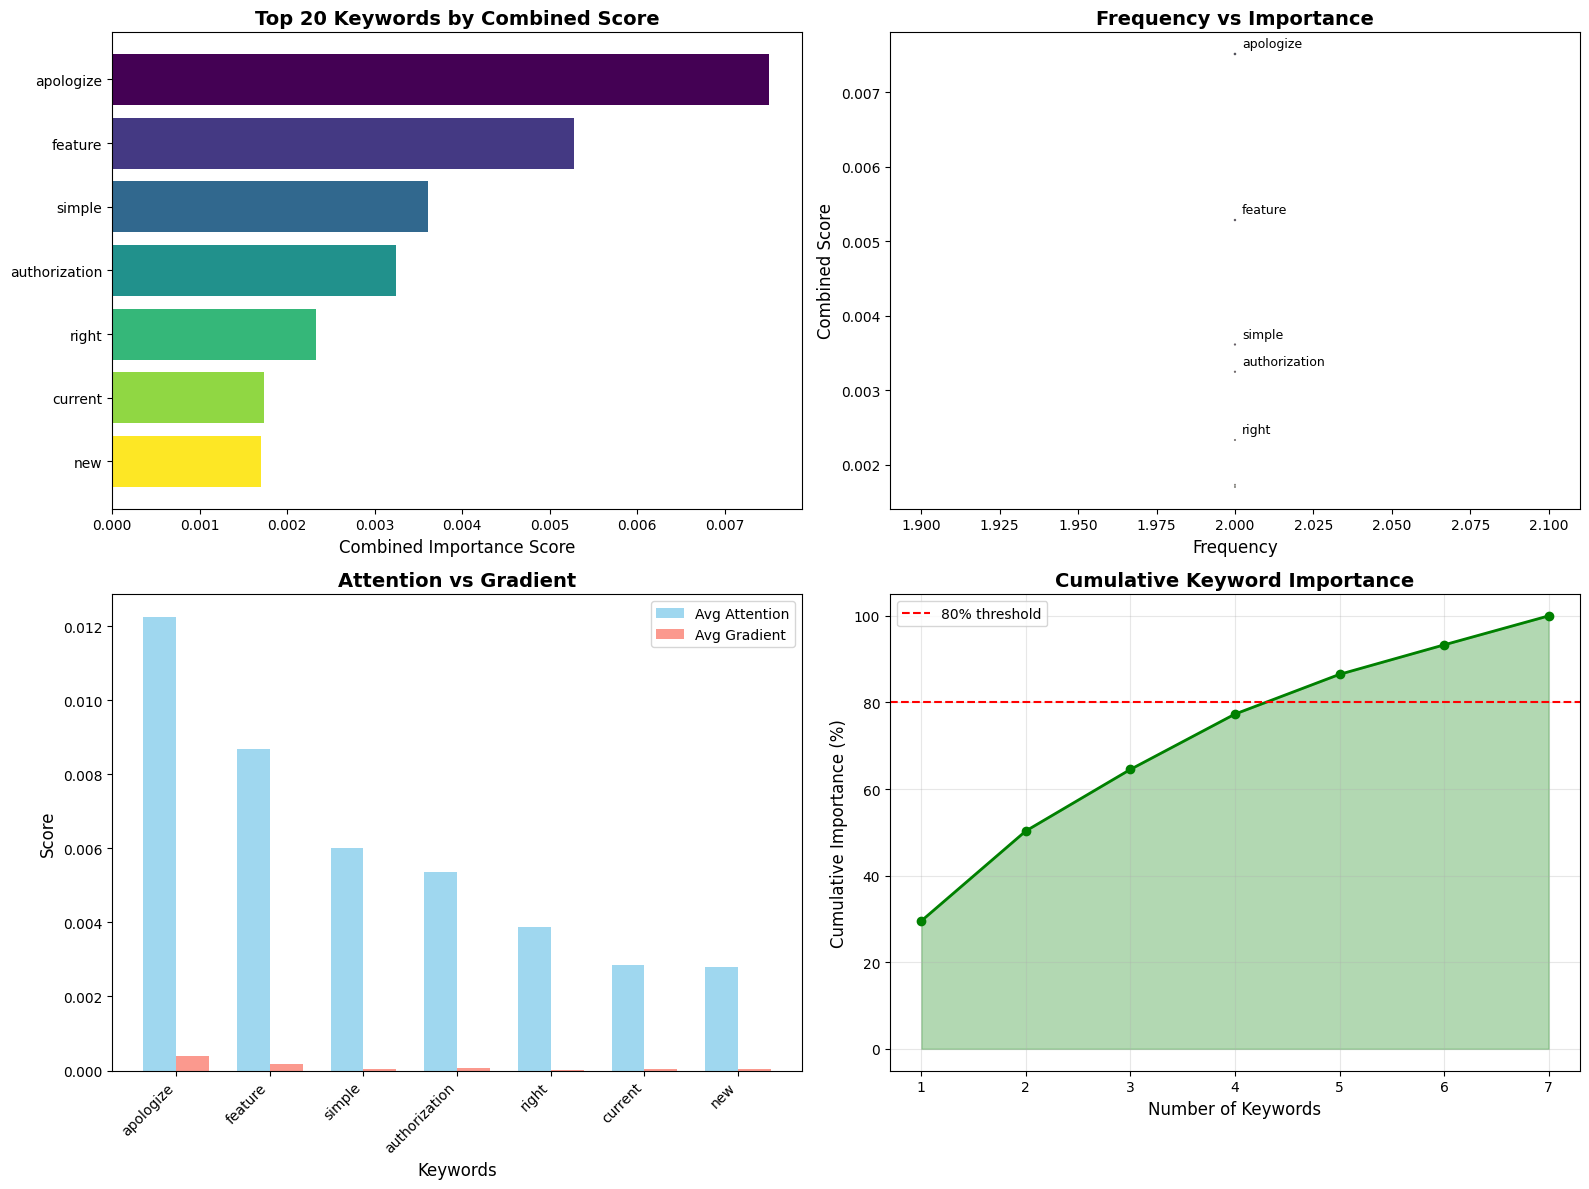

In [53]:
interpret.visualize_keyword_importance(
    results_df=results_df,
    top_n=20,
    save_path="../model/keyword_importance.png"
)

In [54]:
interpret.create_keyword_summary_report(
    results_df=results_df,
    contexts_dict=contexts_dict,
    output_path="../model/keyword_report.html",
    top_n=20
)
print("See:")
print("  - keyword_importance.png")
print("  - keyword_report.html")

GENERATING KEYWORD SUMMARY REPORT
Report saved to: ../model/keyword_report.html
See:
  - keyword_importance.png
  - keyword_report.html
